# Monster API's Instruction Synthesizer API

Instruction synthesizer is a brand new service from MonsterAPI designed to create instruction-response datasets from unlabelled corpora. With just one request, you can easily create datasets for various usecases which is cost effective compared to propieratory models to fine-tune your LLMs.


Checkout our [Developer Docs](https://developer.monsterapi.ai/reference/deploy_instruct_synthesizer_v1_deploy_instruction_synthesizer_post) on how to launch Instruction synthesizer API with no-coding

**Check out our blog on medium that dwels into the details of instruction pre-training and it's benefits - [here](https://medium.com/@raagulbharatwaj/monster-apis-instruction-synthesizer-api-a-new-frontier-in-language-model-development-c7b0ddb78223)**



**The below is a step by step guide on how to create your own instruction-response dataset from a  file using the Instruction synthesizer API**

## Installing dependencies

In [ ]:
%%capture
!pip install langchain langchain_community pypdf
!pip install monsterapi
!pip install huggingface-hub datasets

Sign up on [MonsterAPI](https://monsterapi.ai/signup?utm_source=llm-deploy-colab&utm_medium=referral) and get a free auth key. Paste it below:

In [ ]:
import os
os.environ["MONSTER_API_KEY"] = "Paste Your API KEY here"

# Loading the PDF document and chunking it

Once the above step is done we can load a PDF file and then chunk it.

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

Here, I have taken a book on quantum field theory fine-tuning your LLM on this data can make it answer questions on Quantum mechanics better. Feel free to use your own PDFs !

I am using the langchain's PDF loader to load the pdf file for chunking

In [ ]:
loader = PyPDFLoader("/content/Quantum_Field_Theory_I_Foundations_and_Abelian_and_Non-Abelian_Gauge_Theories.pdf")

Once the PDF file is loaded we have to chunk it into small paragraphs. I am using the recursive charecter splitter to chunk it.

In [ ]:
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

**Note**: The chunk size varies from document to document it is advisable to pick a chunk size that best suits your use case

In [ ]:
len(texts)

1470

We can see that there are 1470 chunks in this PDF now let us print and see a sample chunk.

In [ ]:
texts[0]

Document(metadata={'source': '/content/Quantum Field Theory I_ Foundations and Abelian and Non-Abelian Gauge Theories ( PDFDrive ).pdf', 'page': 0}, page_content='Graduate Texts in Physics\nEdouard B. Manoukian\nQuantum \nField Theory I\nFoundations and Abelian and \nNon-Abelian Gauge Theories')

We can see that these are Langchain's document objects let's convert this to strings using a simple list comprehension and we will be good to go!  

In [ ]:
chunks = [text.page_content for text in texts]
chunks[0]

'Graduate Texts in Physics\nEdouard B. Manoukian\nQuantum \nField Theory I\nFoundations and Abelian and \nNon-Abelian Gauge Theories'

## Creating the Input dataset

Once we have our chunks in the desired format we just have to create an huggingface dataset using it and push it into the the huggingface-hub so that the API can access it.

In [ ]:
import datasets
dataset_dict = {
    'text': chunks
}
hf_dataset = datasets.Dataset.from_dict(dataset_dict)

We can now push the dataset we created above to the hub but forst make sure to login to the hub using a huggingface API key with write permission.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Once logged in we can simply push the dataset using the command below. Fell free to change the input datset name as desired

In [ ]:
hf_dataset.push_to_hub("quantum-field-theory")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/RaagulQB/quantum-field-theory/commit/620efa98b77436c5bae5d7c5f484821410be9cab', commit_message='Upload dataset', commit_description='', oid='620efa98b77436c5bae5d7c5f484821410be9cab', pr_url=None, pr_revision=None, pr_num=None)

## Instantiating the Instruction Synthesizer API to make an instruction-response dataset.

Make sure you point to the correct url, in this case instruction-synthesizer

In [ ]:
import requests
url = "https://api.monsterapi.ai/v1/deploy/instruction-synthesizer"

This code block sets up `payload` for intializing you instruction synthesizer. You can tweak the paramaters like temperature, max_tokens, batch_size and seed to create various versions of the dataset.

Make sure you provide a valid input dataset name and output dataset name while calling the api alongside your huggingface token.

In [ ]:
payload = {
    "model_name": "instruction-pretrain/instruction-synthesizer",
    "temperature": 0,
    "max_tokens": 400,
    "batch_size": 2,
    "seed": 42,
    "input_dataset_name": "RaagulQB/quantum-field-theory",
    "output_dataset_name": "RaagulQB/quantum-field-theory-instruct",
    "hf_token": "<your HF token>"
}
headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "authorization": "Bearer " + os.environ.get("MONSTER_API_KEY")
}

response = requests.post(url, json=payload, headers=headers)

print(response.text)

{"message":"Deployment Launched","servingParams":{"model_name":"instruction-pretrain/instruction-synthesizer","temperature":0.0,"max_tokens":400,"input_dataset_name":"RaagulQB/quantum-field-theory","output_dataset_name":"RaagulQB/quantum-field-theory-instruct","batch_size":2,"seed":42,"deployment_id":"4f42fcd1-b8a2-41a6-bdbb-cb4f210a0f85"},"deployment_id":"4f42fcd1-b8a2-41a6-bdbb-cb4f210a0f85"}


If everything is successfull you will see an success message like above. After a while you can find your dataset on you huggingface-hub.

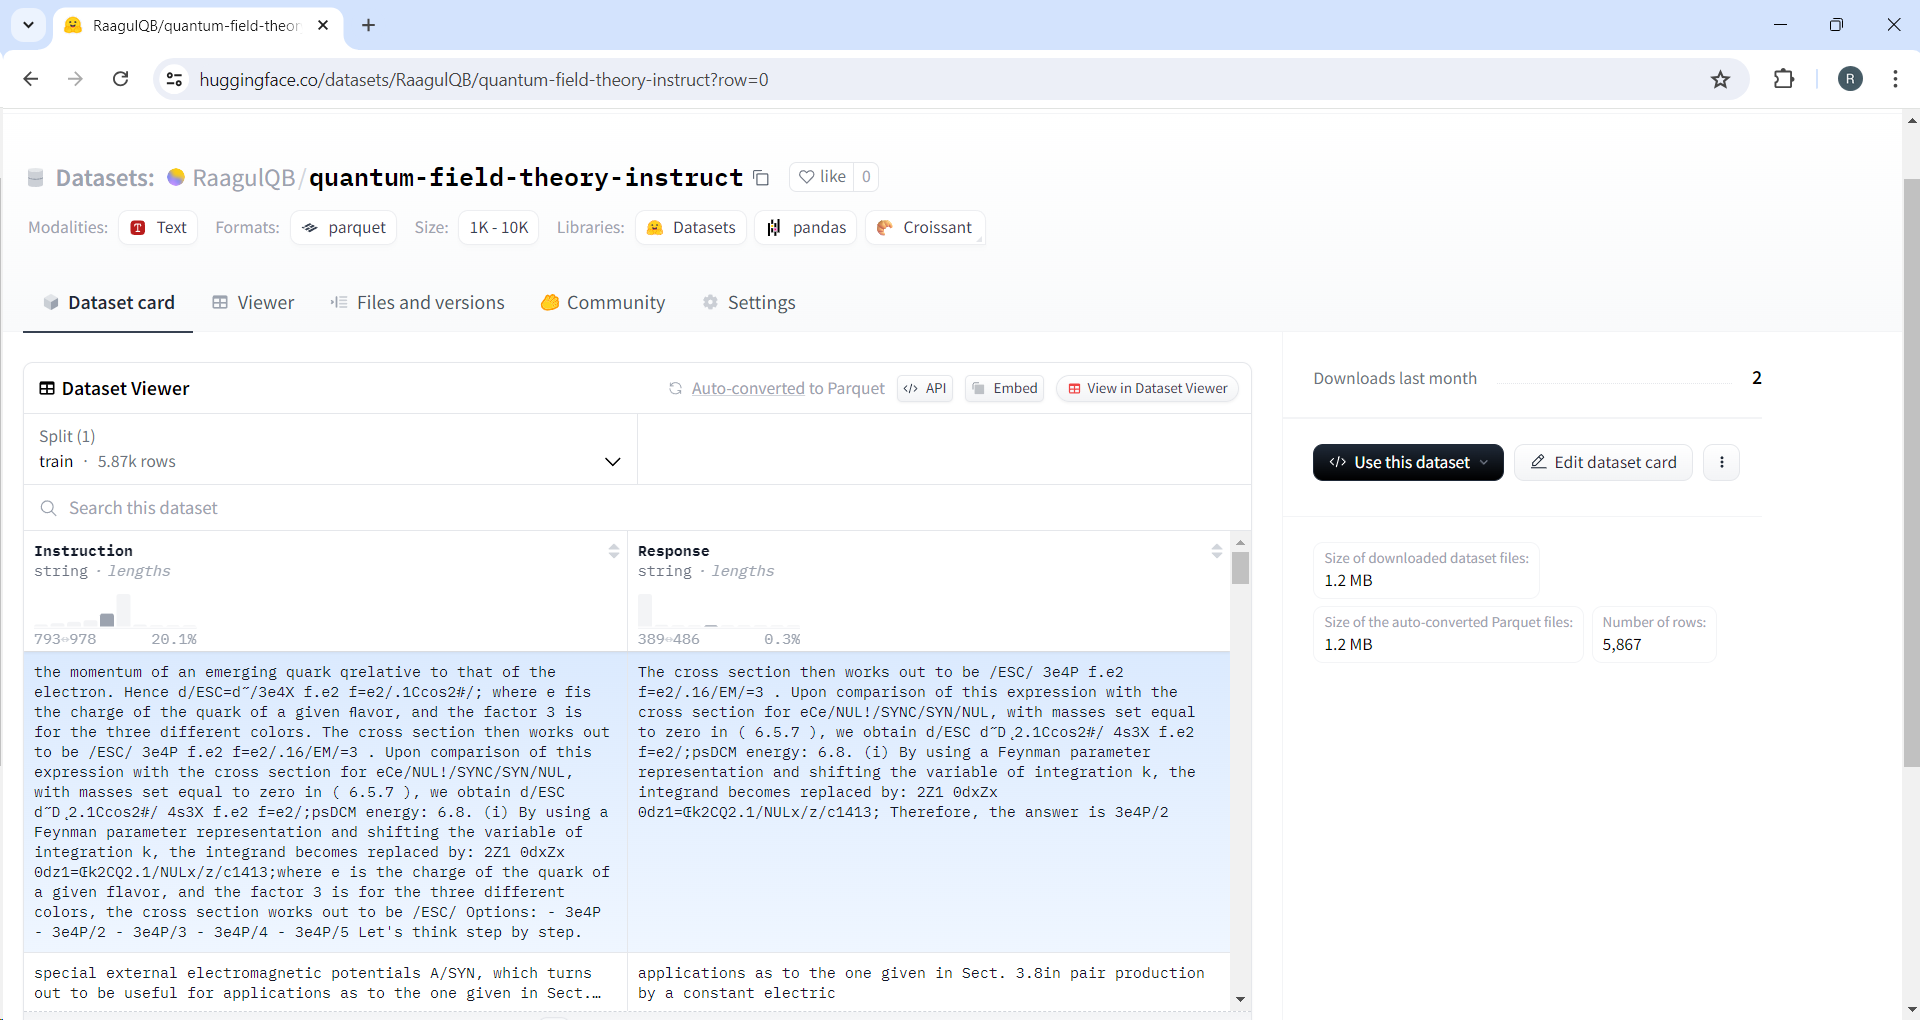

You can now see a neat instruction response dataset created for you which you can use to both pre-train as well fine-tune your LLMs !